# Where's Waldo Detection with Detectron2

This notebook trains a computer vision model to detect Waldo in images using Detectron2.
The process includes:
1. Data preparation and loading
2. Model training
3. Validation with visualization
4. Prediction on unseen test image

## 1. Setup and Dependencies

In [1]:
# Install a specific version of PyYAML

!python -m pip install 'git+https://github.com/facebookresearch/detectron2.git'


  Cloning https://github.com/facebookresearch/detectron2.git to /tmp/pip-req-build-9g5679v2
  Running command git clone --filter=blob:none --quiet https://github.com/facebookresearch/detectron2.git /tmp/pip-req-build-9g5679v2
  Resolved https://github.com/facebookresearch/detectron2.git to commit d38d7161247e64276d4c44d9d0605291e80bd969
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.2/50.2 kB 2.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.3/81.3 kB 5.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.5/154.5 kB 7.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 36.8 MB/s eta 0:00:0000:01
  Created wheel for detectron2: filename=detectron2-0.6-cp311-cp311-linux_x86_64.whl size=6434854 sha256=c201b37e2cad0cc3e36ed56ab995ba94c3d90946ad28232403e442adf758673d
  Stored in directory: /tmp/pip-ephem-wheel-cache-t6z2ch78/wheels/17/d9/40/60db98e485aa

In [2]:
import torch, detectron2
!nvcc --version
TORCH_VERSION = ".".join(torch.__version__.split(".")[:2])
CUDA_VERSION = torch.__version__.split("+")[-1]
print("torch: ", TORCH_VERSION, "; cuda: ", CUDA_VERSION)
print("detectron2:", detectron2.__version__)

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2024 NVIDIA Corporation
Built on Thu_Jun__6_02:18:23_PDT_2024
Cuda compilation tools, release 12.5, V12.5.82
Build cuda_12.5.r12.5/compiler.34385749_0
torch:  2.6 ; cuda:  cu124
detectron2: 0.6


In [3]:
import os
import cv2
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import json
import torch
from torch.utils.data import DataLoader

# Detectron2 imports
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor, DefaultTrainer
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer, ColorMode
from detectron2.data import MetadataCatalog, DatasetCatalog
from detectron2.structures import BoxMode
from detectron2.evaluation import COCOEvaluator, inference_on_dataset
from detectron2.data import build_detection_test_loader

print(f"Detectron2 version: {detectron2.__version__}")
print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")

Detectron2 version: 0.6
PyTorch version: 2.6.0+cu124
CUDA available: True


## 2. Data Loading Functions

In [4]:
def FaireListe(annotations_path):
    """
    Extract file list and count of Waldo instances per image from annotations.
    """
    data = pd.read_csv(annotations_path)
    fileList = data['filename'].unique().tolist()
    nbWaldo = []
    
    for filename in fileList:
        count = len(data[data['filename'] == filename])
        nbWaldo.append(count)
    
    return fileList, nbWaldo

def get_waldo_dicts(img_dir, annotations_path, train=True):
    """
    Prepare dataset dictionaries for Detectron2.
    """
    # Validation indices - images excluded from training
    validateIndex = [350, 164, 153, 171, 368, 94, 22, 257, 37, 241, 201, 276, 198, 21, 335, 208, 139, 354, 202, 260, 55, 273, 344, 178, 120, 214, 169, 16, 98, 222, 42, 279, 1, 159, 312, 359, 135, 345, 48, 264, 317, 258, 293, 129, 17, 362, 91, 101, 269, 243, 320, 195, 123, 213, 306, 112]
    
    data = pd.read_csv(annotations_path)
    fileList, nbWaldo = FaireListe(annotations_path)
    dataset_dicts = []
    
    # Determine which images to use
    ran = list(range(len(fileList)))
    if train:
        # Remove validation indices for training
        for k in validateIndex:
            if k in ran:
                ran.remove(k)
    else:
        # Use only validation indices
        ran = [i for i in validateIndex if i < len(fileList)]
        ran = sorted(ran)
    
    for idx, i in enumerate(ran):
        record = {}
        
        filename = fileList[i]
        rdf = data[data['filename'] == filename].reset_index(drop=True)
        
        # Check if image file exists
        img_path = os.path.join(img_dir, filename)
        if not os.path.exists(img_path):
            print(f"Warning: Image {img_path} not found")
            continue
            
        record["file_name"] = img_path
        record["image_id"] = idx
        record["height"] = int(rdf.iloc[0]['height'])
        record["width"] = int(rdf.iloc[0]['width'])

        objs = []
        for j in range(nbWaldo[i]):
            # Create bounding box coordinates
            xmin = float(rdf.iloc[j]['xmin'])
            ymin = float(rdf.iloc[j]['ymin'])
            xmax = float(rdf.iloc[j]['xmax'])
            ymax = float(rdf.iloc[j]['ymax'])
            
            # Create polygon for segmentation
            px = [xmin, xmin, xmax, xmax]
            py = [ymin, ymax, ymax, ymin]
            poly = [(x + 0.5, y + 0.5) for x, y in zip(px, py)]
            poly = [p for x in poly for p in x]

            obj = {
                "bbox": [xmin, ymin, xmax, ymax],
                "bbox_mode": BoxMode.XYXY_ABS,
                "segmentation": [poly],
                "category_id": 0,
            }
            objs.append(obj)
        record["annotations"] = objs
        dataset_dicts.append(record)
    
    return dataset_dicts

## 3. Dataset Registration

In [5]:
# Define paths - update these to match your directory structure
images_dir = "/kaggle/input/cooooooo"
annotations_path = "/kaggle/input/annotations/annotations.csv"

# Check if paths exist
if not os.path.exists(images_dir):
    print(f"Error: Images directory '{images_dir}' not found")
if not os.path.exists(annotations_path):
    print(f"Error: Annotations file '{annotations_path}' not found")

# Register datasets
for d in ["train", "val"]:
    DatasetCatalog.register("waldo_" + d, lambda d=d: get_waldo_dicts(images_dir, annotations_path, d=="train"))
    MetadataCatalog.get("waldo_" + d).set(thing_classes=["waldo"])

waldo_metadata = MetadataCatalog.get("waldo_train")

# Check dataset sizes
train_dicts = get_waldo_dicts(images_dir, annotations_path, True)
val_dicts = get_waldo_dicts(images_dir, annotations_path, False)

print(f"Training samples: {len(train_dicts)}")
print(f"Validation samples: {len(val_dicts)}")

Training samples: 321
Validation samples: 56


## 4. Visualize Training Data

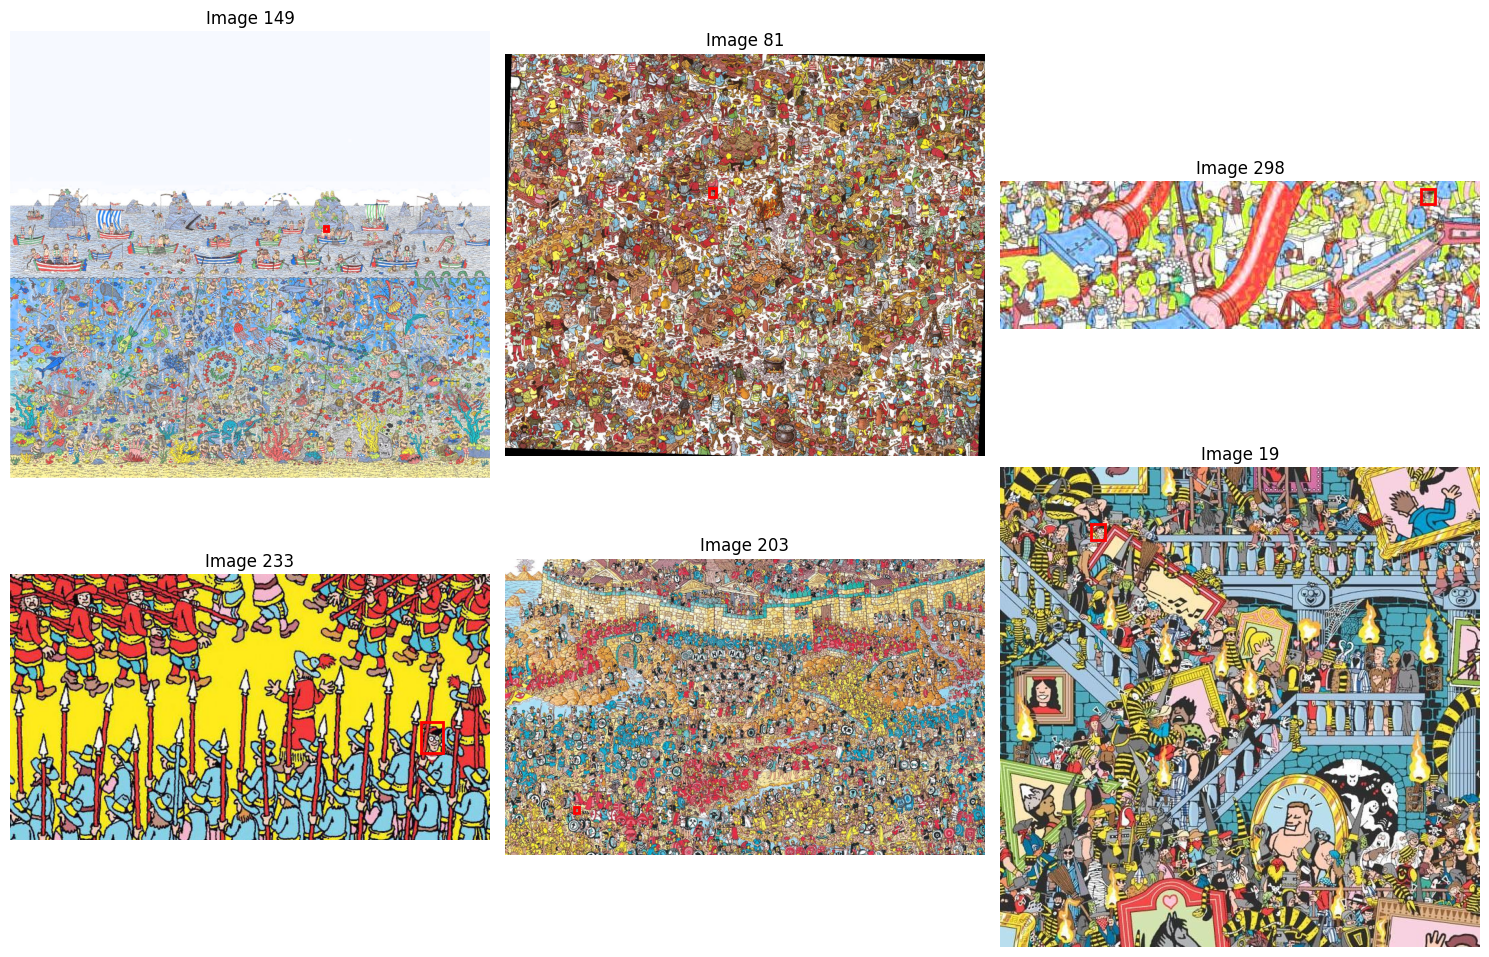

In [6]:
# Visualize some training samples
dataset_dicts = get_waldo_dicts(images_dir, annotations_path, True)

fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.flatten()

for i, d in enumerate(random.sample(dataset_dicts, min(6, len(dataset_dicts)))):
    if i >= 6:
        break
        
    img = cv2.imread(d["file_name"])
    if img is None:
        print(f"Could not load image: {d['file_name']}")
        continue
        
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    axes[i].imshow(img_rgb)
    axes[i].set_title(f"Image {d['image_id']}")
    axes[i].axis('off')
    
    # Draw bounding boxes
    for ann in d["annotations"]:
        bbox = ann["bbox"]
        rect = Rectangle((bbox[0], bbox[1]), bbox[2]-bbox[0], bbox[3]-bbox[1], 
                        linewidth=2, edgecolor='red', facecolor='none')
        axes[i].add_patch(rect)

plt.tight_layout()
plt.show()

## 5. Model Configuration and Training

In [21]:
# Configure the model
cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-Detection/faster_rcnn_R_50_FPN_3x.yaml"))
cfg.DATASETS.TRAIN = ("waldo_train",)
cfg.DATASETS.TEST = ("waldo_val",)
cfg.DATALOADER.NUM_WORKERS = 2
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-Detection/faster_rcnn_R_50_FPN_3x.yaml")
cfg.SOLVER.IMS_PER_BATCH = 2
cfg.SOLVER.BASE_LR = 0.000125
cfg.SOLVER.MAX_ITER = 2500  # Adjust based on your dataset size
cfg.SOLVER.STEPS = []  # No learning rate decay
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 64
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 1  # Only one class: "waldo"

# Set output directory
cfg.OUTPUT_DIR = "./output"
os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)

print("Configuration complete")
print(f"Output directory: {cfg.OUTPUT_DIR}")
print(f"Max iterations: {cfg.SOLVER.MAX_ITER}")
print(f"Learning rate: {cfg.SOLVER.BASE_LR}")

Configuration complete
Output directory: ./output
Max iterations: 2500
Learning rate: 0.000125


In [22]:
# Train the model
print("Starting training...")
trainer = DefaultTrainer(cfg)
trainer.resume_or_load(resume=False)
trainer.train()
print("Training complete!")

Starting training...
[08/15 10:57:02 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
       

## 6. Model Evaluation and Validation

In [23]:
# Configure predictor for inference
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5  # Set threshold for predictions
predictor = DefaultPredictor(cfg)

print("Model loaded for inference")

[08/15 11:18:11 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from ./output/model_final.pth ...
Model loaded for inference


In [24]:
# Evaluate on validation set
evaluator = COCOEvaluator("waldo_val", output_dir="./output")
val_loader = build_detection_test_loader(cfg, "waldo_val")
eval_results = inference_on_dataset(predictor.model, val_loader, evaluator)
print("Evaluation results:")
print(eval_results)

[08/15 11:18:12 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in inference: [ResizeShortestEdge(short_edge_length=(800, 800), max_size=1333, sample_style='choice')]
[08/15 11:18:12 d2.data.common]: Serializing the dataset using: <class 'detectron2.data.common._TorchSerializedList'>
[08/15 11:18:12 d2.data.common]: Serializing 56 elements to byte tensors and concatenating them all ...
[08/15 11:18:12 d2.data.common]: Serialized dataset takes 0.02 MiB
[08/15 11:18:12 d2.evaluation.evaluator]: Start inference on 56 batches
[08/15 11:18:13 d2.evaluation.evaluator]: Inference done 11/56. Dataloading: 0.0017 s/iter. Inference: 0.1289 s/iter. Eval: 0.0003 s/iter. Total: 0.1309 s/iter. ETA=0:00:05
[08/15 11:18:18 d2.evaluation.evaluator]: Inference done 56/56. Dataloading: 0.0021 s/iter. Inference: 0.1113 s/iter. Eval: 0.0002 s/iter. Total: 0.1138 s/iter. ETA=0:00:00
[08/15 11:18:18 d2.evaluation.evaluator]: Total inference time: 0:00:05.861679 (0.114935 s / iter per device, on 1

## 7. Validation Visualization

IndexError: index 6 is out of bounds for axis 0 with size 6

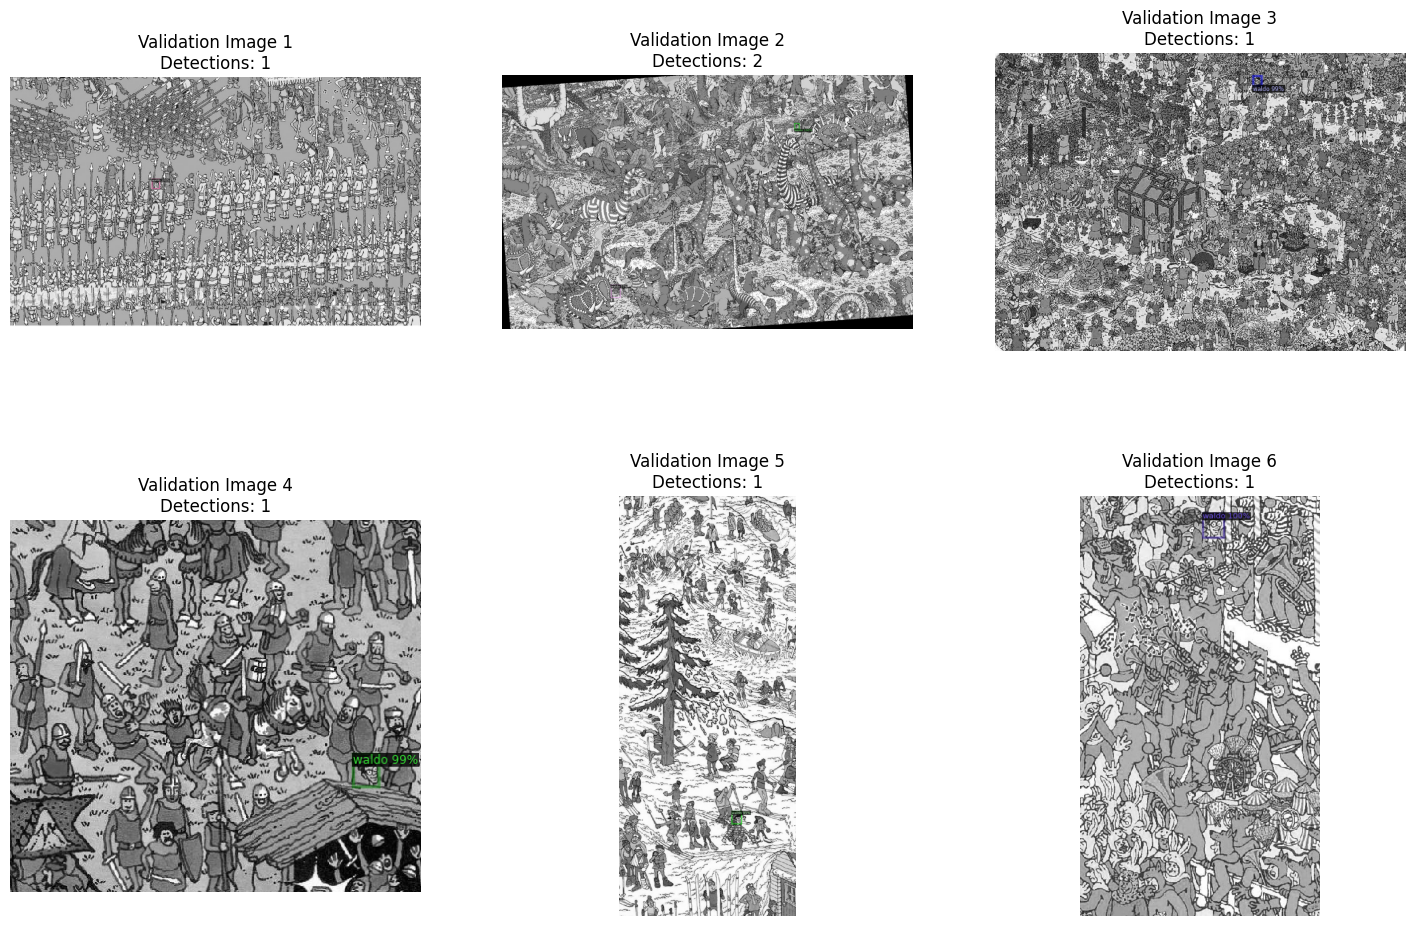

In [26]:
# Visualize predictions on validation set
val_dataset_dicts = get_waldo_dicts(images_dir, annotations_path, False)

fig, axes = plt.subplots(2, 3, figsize=(18, 12))
axes = axes.flatten()

for i, d in enumerate(random.sample(val_dataset_dicts, min(9, len(val_dataset_dicts)))):
    if i >= 9:
        break
        
    img = cv2.imread(d["file_name"])
    if img is None:
        continue
        
    # Make prediction
    outputs = predictor(img)
    
    # Visualize with Detectron2's visualizer
    v = Visualizer(img[:, :, ::-1], 
                   metadata=waldo_metadata, 
                   scale=0.8, 
                   instance_mode=ColorMode.IMAGE_BW)
    out = v.draw_instance_predictions(outputs["instances"].to("cpu"))
    
    axes[i].imshow(out.get_image()[:, :, ::-1])
    axes[i].set_title(f"Validation Image {i+1}\nDetections: {len(outputs['instances'])}")
    axes[i].axis('off')

plt.tight_layout()
plt.show()

## 8. Test on Unseen Image

Testing on: /kaggle/input/cooooooo/image1_wally.jpg


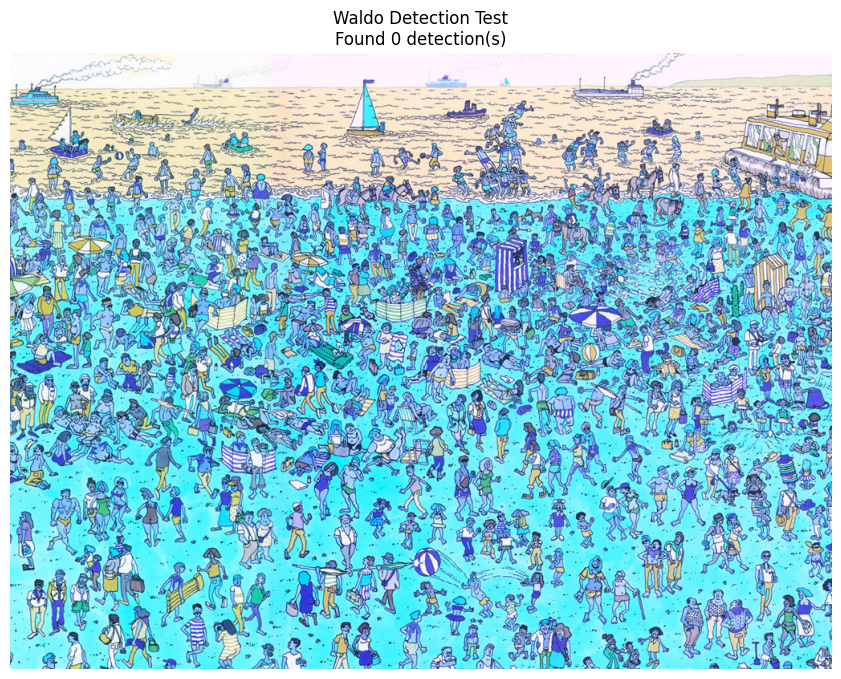

No Waldo detected in this image


In [27]:
# Get a test image that wasn't used in training or validation
all_images = os.listdir(images_dir)
validateIndex = [350, 164, 153, 171, 368, 94, 22, 257, 37, 241, 201, 276, 198, 21, 335, 208, 139, 354, 202, 260, 55, 273, 344, 178, 120, 214, 169, 16, 98, 222, 42, 279, 1, 159, 312, 359, 135, 345, 48, 264, 317, 258, 293, 129, 17, 362, 91, 101, 269, 243, 320, 195, 123, 213, 306, 112]

# Read annotations to get file list
data = pd.read_csv(annotations_path)
fileList = data['filename'].unique().tolist()

# Find images not in training or validation
used_indices = set(validateIndex)
for i in range(len(fileList)):
    if i not in validateIndex:
        used_indices.add(i)

# Find an unused image (if any exist)
test_image_path = None
for img_file in all_images:
    if img_file.lower().endswith(('.png', '.jpg', '.jpeg')):
        if img_file not in fileList:  # Image not in annotations (completely unseen)
            test_image_path = os.path.join(images_dir, img_file)
            break

# If no completely unseen image, use a validation image for demonstration
if test_image_path is None and len(val_dataset_dicts) > 0:
    test_image_path = val_dataset_dicts[0]["file_name"]
    print("Using validation image for test demonstration")

if test_image_path and os.path.exists(test_image_path):
    print(f"Testing on: {test_image_path}")
    
    # Load and predict
    test_img = cv2.imread(test_image_path)
    outputs = predictor(test_img)
    
    # Visualize prediction
    v = Visualizer(test_img[:, :, ::-1], 
                   metadata=waldo_metadata, 
                   scale=1.0, 
                   instance_mode=ColorMode.IMAGE)
    out = v.draw_instance_predictions(outputs["instances"].to("cpu"))
    
    plt.figure(figsize=(12, 8))
    plt.imshow(out.get_image()[:, :, ::-1])
    plt.title(f"Waldo Detection Test\nFound {len(outputs['instances'])} detection(s)")
    plt.axis('off')
    plt.show()
    
    # Print detection details
    instances = outputs["instances"].to("cpu")
    if len(instances) > 0:
        scores = instances.scores.numpy()
        boxes = instances.pred_boxes.tensor.numpy()
        
        print("\nDetection Results:")
        for i, (score, box) in enumerate(zip(scores, boxes)):
            print(f"Detection {i+1}: Confidence = {score:.3f}, Box = [{box[0]:.1f}, {box[1]:.1f}, {box[2]:.1f}, {box[3]:.1f}]")
    else:
        print("No Waldo detected in this image")
else:
    print("No test image available")

## 9. Model Performance Summary

In [28]:
# Summary of training and validation
print("=== WALDO DETECTION MODEL SUMMARY ===")
print(f"Training samples: {len(train_dicts)}")
print(f"Validation samples: {len(val_dicts)}")
print(f"Model: Faster R-CNN with ResNet-50 backbone")
print(f"Training iterations: {cfg.SOLVER.MAX_ITER}")
print(f"Detection threshold: {cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST}")
print(f"Model saved to: {cfg.OUTPUT_DIR}/model_final.pth")

# Check if model file exists
model_path = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")
if os.path.exists(model_path):
    model_size = os.path.getsize(model_path) / (1024*1024)  # Size in MB
    print(f"Model file size: {model_size:.1f} MB")
    print("✅ Training completed successfully!")
else:
    print("❌ Model file not found - training may have failed")

=== WALDO DETECTION MODEL SUMMARY ===
Training samples: 321
Validation samples: 56
Model: Faster R-CNN with ResNet-50 backbone
Training iterations: 2500
Detection threshold: 0.5
Model saved to: ./output/model_final.pth
Model file size: 314.7 MB
✅ Training completed successfully!
